In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from src.utils import load_json

In [16]:
# Load toc

ds_toc = "sprhea_sp_folded_pt"
gs_name = "attention_homology_80_0" # fix_dot_sig_0
gs_path = f"/projects/p30041/spn1560/hiec/artifacts/model_evals/gnn/{ds_toc}_{gs_name}"
toc_path = f"{gs_path}/hp_toc.csv"
hp_toc = pd.read_csv(toc_path, sep='\t')
hp_toc.drop(columns=['Unnamed: 0'], inplace=True)
hp_split_dirs = os.listdir(gs_path)
hp_split_dirs.remove('hp_toc.csv')
hp_split_dirs.remove('gs_params.txt')
hp_toc.head()

,n_epochs,pred_head,message_passing,agg,d_h_mpnn,model,featurizer
0,25,binary,bondwise_dict,attention,20,mpnn_dim_red,rxn_rc
1,25,binary,bondwise_dict,attention,50,mpnn_dim_red,rxn_rc
2,25,binary,bondwise_dict,attention,300,mpnn_dim_red,rxn_rc
3,25,dot_sig,bondwise_dict,attention,20,mpnn_dim_red,rxn_rc
4,25,dot_sig,bondwise_dict,attention,50,mpnn_dim_red,rxn_rc


# Test scores

In [6]:
# Pull scores
tmp_scores = defaultdict(lambda : defaultdict(list))
for hsd in hp_split_dirs:
    hidx = int(hsd.split('_')[0])
    scores = load_json(f"{gs_path}/{hsd}/version_0/test_scores.json")

    for name, val in scores.items():
        tmp_scores[hidx][name].append(val)


# Get new column names
cols = set()
for elt in tmp_scores.values():
    for name in elt.keys():
        cols.add(f"{name}_mean")
        cols.add(f"{name}_std")

# Add new columns
for new in cols:
    hp_toc[new] = pd.Series(dtype='float')

# Fill df w/ scores
for hidx, scores in tmp_scores.items():
    for name, vals in scores.items():
        vals = np.array(vals)
        mean, std = vals.mean(), vals.std()
        hp_toc.loc[hidx, f"{name}_mean"] = mean
        hp_toc.loc[hidx, f"{name}_std"] = std

In [7]:
hp_toc.head()

,n_epochs,pred_head,message_passing,agg,d_h_mpnn,model,precision_std,f1_std,precision_mean,accuracy_std,f1_mean,accuracy_mean,recall_std,recall_mean
0,25,binary,bondwise_dict,attention,20,mpnn_dim_red,0.020702,0.053297,0.928511,0.039566,0.867952,0.879535,0.079842,0.817317
1,25,binary,bondwise_dict,attention,50,mpnn_dim_red,0.020016,0.060382,0.934297,0.044764,0.848674,0.865328,0.092557,0.781458
2,25,binary,bondwise_dict,attention,300,mpnn_dim_red,0.014692,0.060166,0.942814,0.043595,0.861334,0.876551,0.093008,0.797010
3,25,dot_sig,bondwise_dict,attention,20,mpnn_dim_red,0.022197,0.050163,0.927898,0.039105,0.851824,0.865668,0.081167,0.791120
4,25,dot_sig,bondwise_dict,attention,50,mpnn_dim_red,0.020075,0.054765,0.943527,0.043119,0.867524,0.880327,0.086361,0.807040


In [8]:
print(hp_toc.columns)

Index(['n_epochs', 'pred_head', 'message_passing', 'agg', 'd_h_mpnn', 'model',
       'precision_std', 'f1_std', 'precision_mean', 'accuracy_std', 'f1_mean',
       'accuracy_mean', 'recall_std', 'recall_mean'],
      dtype='object')


In [10]:
display_res = hp_toc[['agg', 'pred_head', 'd_h_mpnn', 'f1_mean', 'precision_mean', 'recall_mean', 'accuracy_mean', 'f1_std', 'precision_std', 'recall_std', 'accuracy_std']]
display_res.sort_values(by=['f1_mean'], ascending=False)

,agg,pred_head,d_h_mpnn,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_std,precision_std,recall_std,accuracy_std
5,attention,dot_sig,300,0.877276,0.947169,0.820332,0.888390,0.049619,0.021611,0.078228,0.039240
0,attention,binary,20,0.867952,0.928511,0.817317,0.879535,0.053297,0.020702,0.079842,0.039566
4,attention,dot_sig,50,0.867524,0.943527,0.807040,0.880327,0.054765,0.020075,0.086361,0.043119
2,attention,binary,300,0.861334,0.942814,0.797010,0.876551,0.060166,0.014692,0.093008,0.043595
3,attention,dot_sig,20,0.851824,0.927898,0.791120,0.865668,0.050163,0.022197,0.081167,0.039105
1,attention,binary,50,0.848674,0.934297,0.781458,0.865328,0.060382,0.020016,0.092557,0.044764


In [7]:
binary = display_res.loc[display_res['pred_head'] == 'binary']

In [8]:
# dot_sig = display_res.copy()

In [9]:
tmp_scores

defaultdict(<function __main__.<lambda>()>,
            {2: defaultdict(list,
                         {'f1': [0.9589898611594125,
                           0.9616210413311862,
                           0.962417293938014],
                          'precision': [0.9368107458318089,
                           0.9422500394466944,
                           0.9413120939006497],
                          'recall': [0.9822446295484437,
                           0.9818052282566997,
                           0.984490601194717],
                          'accuracy': [0.9579953967558088,
                           0.9608154765166876,
                           0.961555324162876]}),
             0: defaultdict(list,
                         {'f1': [0.9450514395087328,
                           0.9468062265163714,
                           0.9462824238223455],
                          'precision': [0.9176561693340217,
                           0.927733655919634,
                          

# Loss curves

In [10]:
loss_curves = defaultdict(lambda: defaultdict()) # 'hpidx_sidx': {epochs: [int], losses: [float])
for hsd in hp_split_dirs:
    hidx = int(hsd.split('_')[0])
    lc = pd.read_csv(f"{gs_path}/{hsd}/version_0/metrics.csv", sep=',')
    ep_ave_lc = lc.groupby('epoch').agg('mean').reset_index() # Average over epochs
    loss_curves[hsd]['epochs'] = ep_ave_lc.loc[:, 'epoch'].to_numpy()
    loss_curves[hsd]['losses'] = ep_ave_lc.loc[:, 'train_loss'].to_numpy()



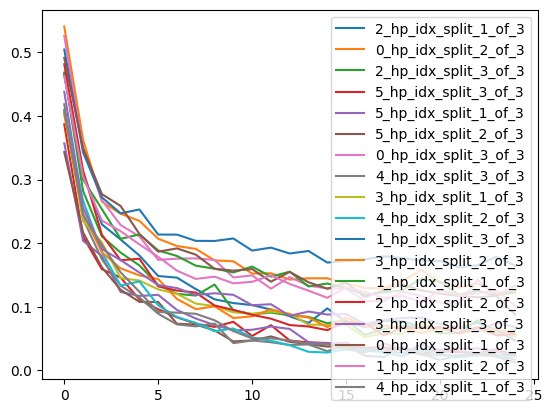

In [11]:
fig, ax = plt.subplots()
for k,v in loss_curves.items():
    ax.plot(v['epochs'], v['losses'], label=k)

ax.legend()
plt.show()

In [12]:
bad_lc = {k:v for k,v in loss_curves.items() if v['losses'][-1] > 0.4}
sorted(bad_lc.keys())

[]

In [13]:
# Collect dot sig and binaryffn

combo = pd.concat([dot_sig, binary])
combo = combo.loc[(combo['agg'] == 'last') & (combo['neg_multiple'] == 2)]

NameError: name 'dot_sig' is not defined

In [ ]:
combo.head()

,agg,pred_head,d_h_mpnn,neg_multiple,f1_mean,precision_mean,recall_mean,accuracy_mean,f1_std,precision_std,recall_std,accuracy_std
1,last,dot_sig,300,2,0.963380,0.949035,0.978170,0.975211,0.000979,0.002331,0.000479,0.000700
3,last,dot_sig,50,2,0.957777,0.940193,0.976033,0.971314,0.001023,0.001957,0.000026,0.000724
5,last,dot_sig,20,2,0.945298,0.924433,0.967137,0.962686,0.003253,0.004915,0.002072,0.002285
1,last,binary,300,2,0.959180,0.945584,0.973202,0.972386,0.001313,0.004752,0.002826,0.000978
3,last,binary,50,2,0.955584,0.937074,0.974846,0.969792,0.000875,0.002363,0.000737,0.000645


In [ ]:
metrics = [
    'f1',
    'precision',
    'recall',
    'accuracy'
]

cluster_conditions = [
    'binary',
    'dot_sig'
]

x_conditions = [
    20,
    50,
    300
]

cluster_col = 'pred_head'
x_col = 'd_h_mpnn'

'''
cluster_condition: {x_idx_condition: (mean, std)}

'''
scores = defaultdict(lambda : defaultdict(lambda : defaultdict(tuple)))
for cc in cluster_conditions:
    for xc in x_conditions:
        for m in metrics:
            mean = combo.loc[(combo[cluster_col] == cc) & (combo[x_col] == xc), f"{m}_mean"].to_numpy()[0]
            std = combo.loc[(combo[cluster_col] == cc) & (combo[x_col] == xc), f"{m}_std"].to_numpy()[0]
            scores[cc][xc][m] = (mean, std)

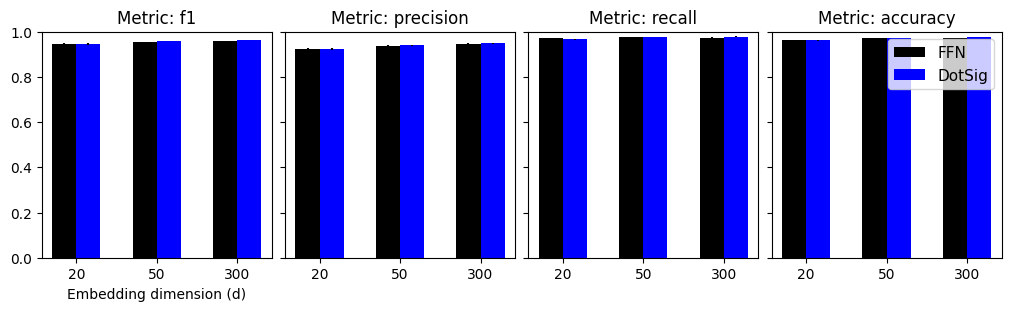

In [ ]:
# Plot esm vs full at all ds tried

# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np


cluster_condition_names = ["FFN", "DotSig"]
colors = ['black', 'blue']

x = np.arange(len(x_conditions))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(10,3), constrained_layout=True)

for i, m in enumerate(metrics):
# for i, d  in enumerate(ds):
    for j, name in enumerate(scores.keys()):
        data = [scores[name][d][m] for d in x_conditions]
        # x = list(data.keys())
        mu, sig = list(zip(*data))
        offset = width * (j - 0.5)
        rects = ax[i].bar(x + offset, mu, yerr=sig, width=width, label=cluster_condition_names[j], color=colors[j])
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(x_conditions)
        ax[i].set_title(f"Metric: {m}")

ax[-1].legend(loc='upper right', fontsize=11)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Embedding dimension (d)")


plt.show()

# Check for data leak

In [14]:
scratch_dir = '/scratch/spn1560'
test_path = f"{scratch_dir}/sprhea_sp_folded_pt_3_splits_1234_seed_1_neg_multiple_0_split_idx_test.npy"
train_path = f"{scratch_dir}/sprhea_sp_folded_pt_3_splits_1234_seed_1_neg_multiple_0_split_idx_train.npy"

train_data = np.load(train_path)
test_data = np.load(test_path)

In [ ]:
leaked = []
for i in range(len(test_data)):
    for j in range(len(train_data)):
        embeds_equal = all(test_data['sample_embed'][i] == train_data['sample_embed'][j])
        rxns_equal = test_data['feature'][i] == train_data['feature'][j]
        if embeds_equal and rxns_equal:
            print((i, j))



(6642, 59216)
(17534, 15195)


In [17]:
test_data[6642], train_data[59216]

(([-7.39624500e-02,  2.88149476e-01,  9.15787444e-02, ..., -3.64124365e-02, -1.16873235e-01, -2.98373606e-02], 'R4ce924f53b2ec0e64f1d8b9c5e3103a9349a280021c761657532b3cc22f39c99', 1),
 ([-7.39624500e-02,  2.88149476e-01,  9.15787444e-02, ..., -3.64124365e-02, -1.16873235e-01, -2.98373606e-02], 'R4ce924f53b2ec0e64f1d8b9c5e3103a9349a280021c761657532b3cc22f39c99', 0))

In [18]:
test_data[17534], train_data[15195]

(([ 2.62955893e-02,  1.72108307e-01, -9.06688944e-02, ..., -1.08067848e-01,  4.51614335e-02, -3.35152168e-03], 'Rd3d797e65d6e4f615f8ff6ed530cb2c84f8434ae6f0f8f4fb80c7d8593d0bc30', 1),
 ([ 2.62955893e-02,  1.72108307e-01, -9.06688944e-02, ..., -1.08067848e-01,  4.51614335e-02, -3.35152168e-03], 'Rd3d797e65d6e4f615f8ff6ed530cb2c84f8434ae6f0f8f4fb80c7d8593d0bc30', 0))

In [19]:
len(train_data), len(test_data)

(72988, 36496)